In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
#data = genfromtxt('small_file.txt', delimiter=',')
data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
print(data)

[[ 0.          1.128016    0.913283   -2.69977     0.27121927]
 [ 1.          0.952915    0.519144    0.878809    0.95261156]
 [ 1.          0.434082    0.56767    -2.311936    0.93668561]
 [ 2.          2.209619    1.105468    2.333682    0.52416023]
 [ 3.          1.71197     1.189179    1.119164    0.78435412]
 [ 3.          0.461599    0.777167   -0.144536    0.75403444]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.68407621]
 [ 6.          2.1872      0.476108    2.85122     0.8842718 ]
 [ 7.          1.921325    1.287711   -2.407052    1.        ]
 [ 7.          0.24677     0.972258    1.512456    0.95922116]
 [ 8.          2.12424     1.190137    0.532672    0.63181968]
 [ 9.          2.165567    0.780356    1.333373    0.52338727]
 [10.          1.927867    0.979187   -1.390222    0.83159162]
 [10.          0.155214    1.058012   -2.217043    0.81032574]
 [11.          2.17151     0.581699   -0.050691    0.75

### reshape data

In [3]:
#print(np.min(data,axis=0)[0])
ll = []
true_vals = []
print(int(np.max(data,axis=0)[0]))
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    #print("This is mask:")
    #print(mask)
    evt = data[mask]
    #print(evt)
    #print(evt.shape[0])
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    for i, (idx1, idx2) in enumerate(pair_indices):
        l = []
        l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
        ll.append(l)
        if (evt[idx1,0] == evt[idx2,0]):
            true_vals.append(1)
        else:
            true_vals.append(0)
#print(ll)
input_data = torch.FloatTensor(ll)
input_data = torch.squeeze(input_data)
input_data.shape
truth_class = torch.FloatTensor(true_vals)
print(input_data.shape)
print(truth_class.shape)

29
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (1, 2)]
torch.Size([57, 8])
torch.Size([57])


/home/tobiasjenegger/jupy/jup_notebook/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


### simple model

In [4]:
class feed_forward_model(nn.Module):
        def __init__(self,nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                #self.another_linear = torch.nn.Linear(100,100)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                #output_tensor = self.activation(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor


## final training

In [5]:
print(input_data.shape)
n_epochs = 1000
model = feed_forward_model(100)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.SGD(model.parameters(), lr=9e-4)
model.train()
loss_val = []
for epoch in range(n_epochs):
    y_pred = model(input_data)
    y_true = truth_class
    loss = loss_fn(y_pred,y_true)
    loss_val.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")

torch.Size([57, 8])
Finished epoch 0, latest loss 0.7746431231498718
Finished epoch 1, latest loss 0.768436074256897
Finished epoch 2, latest loss 0.7623367309570312
Finished epoch 3, latest loss 0.7563431859016418
Finished epoch 4, latest loss 0.7504538297653198
Finished epoch 5, latest loss 0.7446669936180115
Finished epoch 6, latest loss 0.7389810085296631
Finished epoch 7, latest loss 0.7333942651748657
Finished epoch 8, latest loss 0.7279051542282104
Finished epoch 9, latest loss 0.722511887550354
Finished epoch 10, latest loss 0.7172130346298218
Finished epoch 11, latest loss 0.7120068669319153
Finished epoch 12, latest loss 0.7068919539451599
Finished epoch 13, latest loss 0.701866626739502
Finished epoch 14, latest loss 0.6969293355941772
Finished epoch 15, latest loss 0.6920785903930664
Finished epoch 16, latest loss 0.6873128414154053
Finished epoch 17, latest loss 0.6826305985450745
Finished epoch 18, latest loss 0.6780303716659546
Finished epoch 19, latest loss 0.6735107898

Finished epoch 282, latest loss 0.38909876346588135
Finished epoch 283, latest loss 0.38891804218292236
Finished epoch 284, latest loss 0.3887385427951813
Finished epoch 285, latest loss 0.3885602653026581
Finished epoch 286, latest loss 0.3883831202983856
Finished epoch 287, latest loss 0.3882071375846863
Finished epoch 288, latest loss 0.38803234696388245
Finished epoch 289, latest loss 0.38785868883132935
Finished epoch 290, latest loss 0.3876861035823822
Finished epoch 291, latest loss 0.3875146508216858
Finished epoch 292, latest loss 0.3873443007469177
Finished epoch 293, latest loss 0.3871750831604004
Finished epoch 294, latest loss 0.38700684905052185
Finished epoch 295, latest loss 0.38683974742889404
Finished epoch 296, latest loss 0.38667362928390503
Finished epoch 297, latest loss 0.38650864362716675
Finished epoch 298, latest loss 0.3863446116447449
Finished epoch 299, latest loss 0.3861815929412842
Finished epoch 300, latest loss 0.38601958751678467
Finished epoch 301, la

Finished epoch 532, latest loss 0.3622114360332489
Finished epoch 533, latest loss 0.36213788390159607
Finished epoch 534, latest loss 0.3620644509792328
Finished epoch 535, latest loss 0.36199113726615906
Finished epoch 536, latest loss 0.36191797256469727
Finished epoch 537, latest loss 0.36184489727020264
Finished epoch 538, latest loss 0.36177191138267517
Finished epoch 539, latest loss 0.36169904470443726
Finished epoch 540, latest loss 0.3616262972354889
Finished epoch 541, latest loss 0.36155369877815247
Finished epoch 542, latest loss 0.3614811897277832
Finished epoch 543, latest loss 0.3614087700843811
Finished epoch 544, latest loss 0.36133649945259094
Finished epoch 545, latest loss 0.36126428842544556
Finished epoch 546, latest loss 0.36119216680526733
Finished epoch 547, latest loss 0.36112022399902344
Finished epoch 548, latest loss 0.3610483705997467
Finished epoch 549, latest loss 0.36097657680511475
Finished epoch 550, latest loss 0.3609049618244171
Finished epoch 551,

Finished epoch 719, latest loss 0.3499085307121277
Finished epoch 720, latest loss 0.3498483896255493
Finished epoch 721, latest loss 0.3497883081436157
Finished epoch 722, latest loss 0.3497282564640045
Finished epoch 723, latest loss 0.3496682345867157
Finished epoch 724, latest loss 0.34960833191871643
Finished epoch 725, latest loss 0.3495483994483948
Finished epoch 726, latest loss 0.3494885563850403
Finished epoch 727, latest loss 0.3494287431240082
Finished epoch 728, latest loss 0.34936895966529846
Finished epoch 729, latest loss 0.34930920600891113
Finished epoch 730, latest loss 0.3492495119571686
Finished epoch 731, latest loss 0.3491898477077484
Finished epoch 732, latest loss 0.3491303026676178
Finished epoch 733, latest loss 0.3490707278251648
Finished epoch 734, latest loss 0.34901121258735657
Finished epoch 735, latest loss 0.3489517271518707
Finished epoch 736, latest loss 0.34889230132102966
Finished epoch 737, latest loss 0.348832905292511
Finished epoch 738, latest 

Finished epoch 915, latest loss 0.3388368487358093
Finished epoch 916, latest loss 0.33878347277641296
Finished epoch 917, latest loss 0.338730126619339
Finished epoch 918, latest loss 0.3386768102645874
Finished epoch 919, latest loss 0.338623583316803
Finished epoch 920, latest loss 0.3385702967643738
Finished epoch 921, latest loss 0.33851709961891174
Finished epoch 922, latest loss 0.3384639322757721
Finished epoch 923, latest loss 0.33841076493263245
Finished epoch 924, latest loss 0.3383576571941376
Finished epoch 925, latest loss 0.3383045196533203
Finished epoch 926, latest loss 0.3382514715194702
Finished epoch 927, latest loss 0.3381984531879425
Finished epoch 928, latest loss 0.3381454050540924
Finished epoch 929, latest loss 0.3380924165248871
Finished epoch 930, latest loss 0.33803945779800415
Finished epoch 931, latest loss 0.3379864990711212
Finished epoch 932, latest loss 0.33793362975120544
Finished epoch 933, latest loss 0.3378807008266449
Finished epoch 934, latest l

Text(0, 0.5, 'loss value')

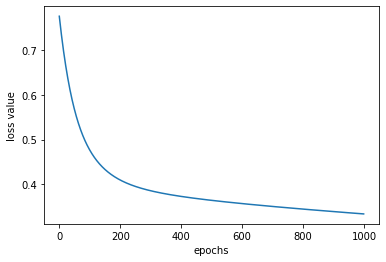

In [6]:
plt.plot(loss_val)
plt.xlabel("epochs")
plt.ylabel("loss value")

### look at pred. value distributions

In [7]:
#ff_model = feed_forward_model()
with torch.no_grad():
    model = torch.load("ff_scripted.pt")
    model.eval()
    
eval_pred = model(input_data).detach().numpy()   
eval_true = truth_class.detach().numpy()




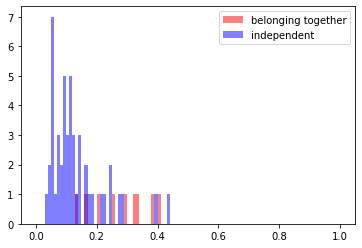

In [8]:
plt.hist(eval_pred[eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(eval_pred[eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.legend()

In [9]:
def run(parameter,min_val,max_val,steps):
    learning_rate = 9e-4
    nodes = 1000
    if (parameter == "lr"):
        for i in range(min_val,max_val,steps):
            optimizer = optim.SGD(model.parameters(), lr=i)
            model.train()
            loss_val = []
            for epoch in range(n_epochs):
                y_pred = model(input_data)
                y_true = truth_class
                loss = loss_fn(y_pred,y_true)
                loss_val.append(loss.detach().item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        
        
        lr
    if (parameter == "nodes"):
        
    n_epochs = 1000
    model = feed_forward_model()
    loss_fn = nn.BCELoss()  # binary cross entropy
    
    for 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

IndentationError: expected an indented block (<ipython-input-9-573dbff2ceef>, line 6)